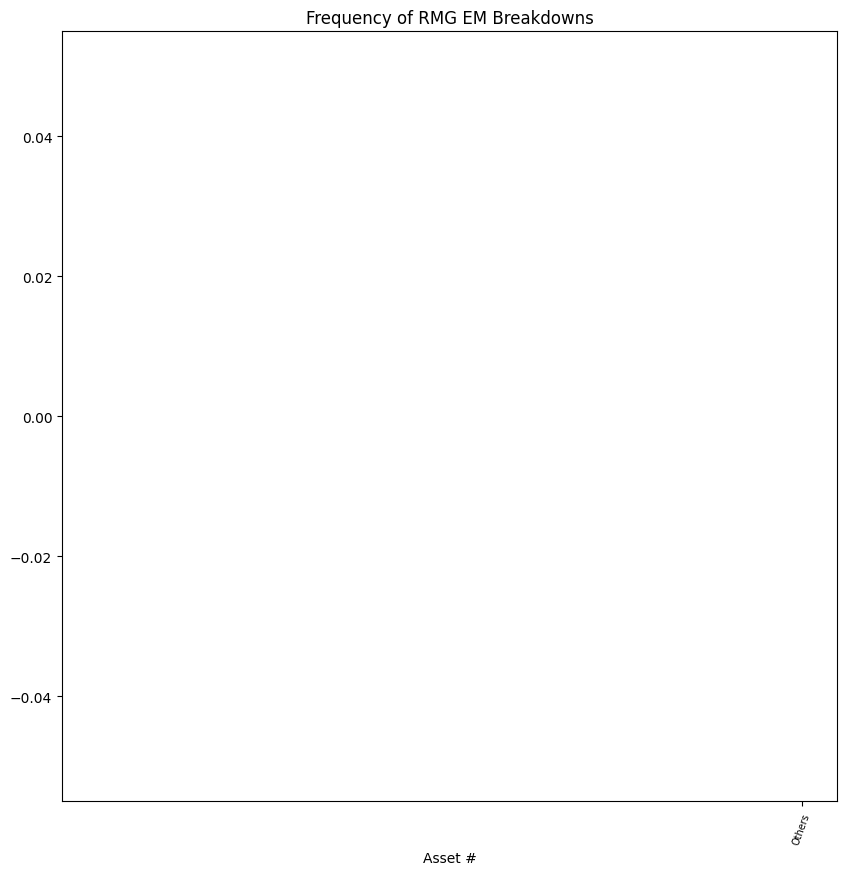

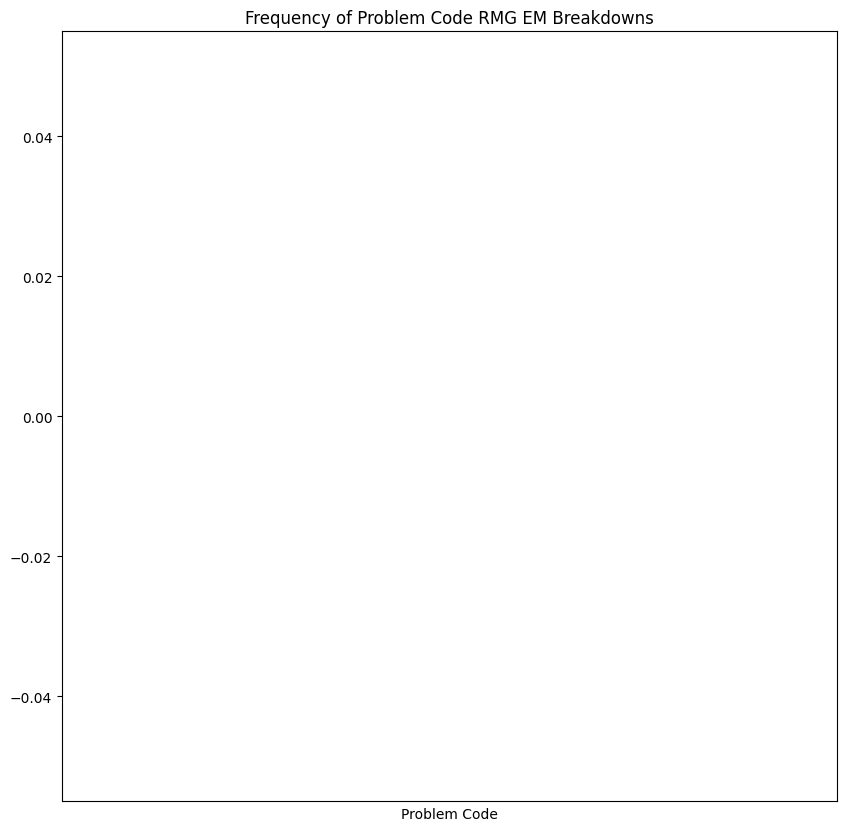

In [7]:
#Frequency of Problem Codes and EM Breakdowns for Asset #
import pandas as pd
import matplotlib.pyplot as plt

#Reading CSV file and filtering the data out for RTG's (Type) and the Problem Codes that you dont want to include
df = pd.read_csv("test.csv")
filter_type = input('Asset Type: ')
df = df[df['Type']==filter_type] #Can be an input

#Asset Maintenance Frequency
asset_count = df['Asset #'].value_counts().to_dict()
df2 = pd.DataFrame(asset_count.items(), columns =['asset', 'count'])
df2 = df2.sort_values(by='count')
others_sum = []
for count in df2['count']:
    if count <= 50:
        others_sum.append(count)
        df2.drop(df2[df2['count'] <= 50].index, inplace = True)
others = pd.DataFrame({"asset": ["Others"], "count": [sum(others_sum)]})
df2_1 = pd.concat([others, df2])

plt.figure(1)
plt.rcParams["figure.figsize"] = (10,10)
bar_width_1 = 1.5 
spacing_factor_1 = 2
total_width_1 = bar_width_1 + spacing_factor_1
x_positions_1 = [i * total_width_1 for i in range(len(df2_1['asset']))]
plt.bar(x_positions_1, df2_1['count'], width=bar_width_1, color='green')
plt.xticks([pos + bar_width_1 / 2 for pos in x_positions_1], df2_1['asset'], rotation=70, fontsize=7)

plt.xlabel('Asset #')
plt.title('Frequency of ' + filter_type +' EM Breakdowns' )

plt.savefig('Assets.png')

#Problem Code Frequency
pc_count = df['Problem\r\nCode'].value_counts().to_dict()
df3 = pd.DataFrame(pc_count.items(), columns = ['pc', 'count'])
df3 = df3.sort_values(by='count')

plt.figure(2)
bar_width_2 = 1.5 
spacing_factor_2 = 2
total_width_2 = bar_width_2 + spacing_factor_2
x_positions_2 = [i * total_width_2 for i in range(len(df3['pc']))]
plt.bar(x_positions_2, df3['count'], width=bar_width_2, color='green')
plt.xticks([pos + bar_width_2 / 2 for pos in x_positions_2], df3['pc'], rotation=45, fontsize=7)

plt.xlabel('Problem Code')
plt.title('Frequency of Problem Code ' + filter_type +' EM Breakdowns')

plt.savefig('Problem_Code.png')

In [8]:
#Filtering Data Based on Input
problem_filter = []
list_length = 3
for i in range(list_length):
    n = i+1
    problem = input('Which Problem Codes do you want a Summary of? Enter Problem Code ' + str(n) + "/3 : " )
    problem_filter.append(problem)

df1 = pd.DataFrame()
for problem in problem_filter:
    new_df = df[df["Problem\r\nCode"] == problem]
    df1 = pd.concat([df1, new_df], ignore_index=True)

In [9]:
#Autocorrecting all descriptions and putting it into a new dataframe
import spacy
import enchant

nlp = spacy.load("en_core_web_sm")
spellchecker = enchant.Dict("en_US")

description = df['Description']
work_log = df['Work Log']

def autocorrect(text):
    if isinstance(text, float):
        return str(text)  # Convert float to string
    
    if not isinstance(text, str):
        return text
    doc = nlp(text)
    corrected_text = []
    for token in doc:
        if not spellchecker.check(token.text):
            suggestion = spellchecker.suggest(token.text)
            if suggestion:
                corrected_text.append(suggestion[0])
            else:
                corrected_text.append(token.text)
        else:
            corrected_text.append(token.text)

    return " ".join(corrected_text)

corrected_description = df1['Description'].apply(lambda x: autocorrect(x))
df4 = df1.replace(description, corrected_description)

corrected_work_log = df4['Work Log'].apply(lambda x: autocorrect(x))
df5 = df4.replace(work_log, corrected_work_log)

ModuleNotFoundError: No module named 'enchant'

In [ ]:
#Organizing into PC 
pc = df1['Problem\r\nCode'].unique()
df6 = df5.loc[:,["Problem\r\nCode","Cause Code", "Description", "Work Log"]]
dfs = []
df7 = {}

for code in pc:
    new_df = df6[df6['Problem\r\nCode']==code].dropna()
    dfs.append(new_df.sort_values(by = "Cause Code").reset_index(drop=True))

for key, value in enumerate(dfs):
    df7[pc[key]] = value
    
#Organizing into CC
count_cc = []
cause_cc = []
cc = []
dfn = []
df8 = {}

for code in pc:
    ccdf = df7[code]
    cc_count = ccdf["Cause Code"].value_counts().to_dict()
    count_cc.append(list(cc_count.values()))
    cause_cc.append(list(cc_count.keys()))
    for cause, count in cc_count.items():
        if count > 100:#Could be an input, filter based on how many you think there should be
            new_df = ccdf[ccdf['Cause Code']==cause]
            dfn.append(new_df.sort_values(by = "Description").reset_index(drop=True))
            cc.append(cause)
        else:
            pass

for key, value in enumerate(dfn):
    df8[cc[key]] = value

image_paths = []

for i in range(3): #Just the first three most common Problem Code Cause Code Graphs
    plt.figure(i)
    plt.rcParams["figure.figsize"] = (10,10)
    bar_width_1 = 1.5 
    spacing_factor_1 = 2
    total_width_1 = bar_width_1 + spacing_factor_1
    x_positions_1 = [i * total_width_1 for i in range(len(cause_cc[i]))]
    plt.bar(x_positions_1, count_cc[i], width=bar_width_1, color='green')
    plt.xticks([pos + bar_width_1 / 2 for pos in x_positions_1], cause_cc[i], rotation=45, fontsize=8)
    plt.xlabel('Cause Code')
    plt.title(pc[i] + ": Cause Code Frequency Breakdowns")

    image_path = f"plot_{i+1}.png"
    plt.savefig(image_path)
    image_paths.append(image_path)
    plt.close()



In [ ]:
import cohere
co = cohere.Client("soyz0L4mhFJmfoFv3EyEZuGfq0jvcu5Jb9WF8Yba")

def summarize(text, co):
    response = co.summarize(
        text=text,
        model='summarize-xlarge',
        length='medium',
        format='bullets',
        additional_command='making it evident what the most common problems were and what was done to fix them, while using third person language',
        temperature=2,
        extractiveness= "medium",
    )

    summary = response.summary
    return summary

def chunk_text(text, max_chars):
    chunks = []
    current_chunk = ""

    for word in text.split():
        word_length = len(word)  # Length of the current word

        if len(current_chunk) + word_length <= max_chars:
            current_chunk += " " + word
        else:
            chunks.append(current_chunk.strip())
            current_chunk = word

    if current_chunk:
        chunks.append(current_chunk.strip())

    return chunks

max_chars_per_chunk = 100000

for cause in cc[:3]:
    df = df8[cause]
    work_log =df["Work Log"]
    text = " ".join(work_log)
    print("-------------------------")
    print(str(df['Problem\r\nCode'].unique()[0]) + ": " + cause + " Summary")

    text_chunks = chunk_text(text, max_chars_per_chunk)
    for chunk in text_chunks:
        chunk_summary = summarize(chunk, co)
        print(chunk_summary)

-------------------------
SYS: GPS FLT Summary
- During a six month period, various GPS related issues were addressed and fixed.
- The problems included: GPS system hang, GPS mode 5, GPS left and right signal interference, GPS top and down side receiver faults, and other issues.
- The issues were fixed by power cycling the system, checking the power supply, and performing rail offset calibration.
- In some cases, the GPS receivers were replaced and the system was reset.
- The issues were intermittent and sometimes went away on their own.
- In some cases, the operators were instructed to do manual operations until the GPS system was fixed.
-------------------------
SYS: VMT FLT Summary
- One of the primary roles of a system technician is to resolve any technical issues that arise during the day-to-day operation of the VMT system.
- System technicians need to be familiar with VMT and have good knowledge of networks, and communication protocols to help with the diagnosis of the problem an

In [ ]:
#Creating a PDF File
"""from fpdf import FPDF

WIDTH = 210
HEIGHT = 297

pdf = FPDF() 
  
pdf.add_page() 
 
pdf.set_font("Arial", size = 14) 
 
# create a cell 
pdf.cell(200, 10, txt = "EM Report Summary", 
        ln = 1, align = 'C') 
for image_path in image_paths:
    pdf.image(image_path, x=10, y=pdf.get_y(), w=100)
    pdf.ln(100)
pdf.image('Assets.png', 5, 30, WIDTH/2 -5)
pdf.image('Problem_Code.png', WIDTH/2 + 5, 30, WIDTH/2 -5)
pdf.output("EM_Summary.pdf")""" 

'from fpdf import FPDF\n\nWIDTH = 210\nHEIGHT = 297\n\npdf = FPDF() \n  \npdf.add_page() \n \npdf.set_font("Arial", size = 14) \n \n# create a cell \npdf.cell(200, 10, txt = "EM Report Summary", \n        ln = 1, align = \'C\') \nfor image_path in image_paths:\n    pdf.image(image_path, x=10, y=pdf.get_y(), w=100)\n    pdf.ln(100)\npdf.image(\'Assets.png\', 5, 30, WIDTH/2 -5)\npdf.image(\'Problem_Code.png\', WIDTH/2 + 5, 30, WIDTH/2 -5)\npdf.output("EM_Summary.pdf")'